## Structural Equivalence and Random Walk Embeddings

Outline
 - teachers in the 2020 winter graph graph
 - structural equivalence notions
    - first example from 
        ```
            Introduction to Social Network Methods. Chapter 12: Network Positions and Social Roles: The idea of Equivalence. R. A. Hanneman. Free online text.
        ```
    - second example from 
        ``` 
            Networks. Mark Newman. Second Edition Chapter 7, figure 7.11
        ```
    - pinwheel graph example
 - structural equivalence definitions from Hanneman's book
 - deep walk and random walk embeddings
 - PageRank and random walk embeddings
 - Node2vec
    ``` 
        Grover, A., & Leskovec, J. (2016, August). node2vec: Scalable feature learning for networks. In Proceedings of the 22nd ACM SIGKDD international conference on Knowledge discovery and data mining (pp. 855-864).
    ```
    - when are nodes equivalent: homophily and structure: "[N]odes in networks could be organized based on communities they belong to (_e.g., homophily_) [or] on the structural roles in the network (_i.e., structural equivalence_)" [Section 1].
    ``` 
    - depth first random walks capture structural equivalence
    - breadth first random walks capture community equivalence
    - node2vec tries to blend both

---

### Looking for Local Graph Structures

Consider the network of students and faculty in the same classroom from Fall 2019.

<img src="figures/ClassFall2019.png" alt="graph of who is in whose classroom Fall 2019" width = "500">

I've circled a few objects of interest in the network. The objects in the purple circles are classes where most of the students are only taking one class. Thus, they form cliques. Notice how the objects are complete graphs. Notice further that either a few of the students or perhaps the professor are taking/teaching another class, causing at least node in the complete clique to be connected to other nodes. The objects in the orange-ish circles have a type of hierarchical structure where all the nodes in the small cliques are connected to nodes outside of the cliques, but the nodes outside the cliques are not fully connected to each other.

This network highlights an important feature of networks: different subgraphs in the networks can have roughly the same structures, even if there is nothing else in common among the nodes in the networks. In the figure above, the structures arise from the way classes are organized, and the structures appear in very different parts of the graph, suggesting that the same structures exist at very different places in the university (different majors, different colleges, etc.). Stating this observation simply, it is common for different subgraphs in a network to have very similar structures. This leads to the notion of __structural equivalence__.

---
We've encountered structural equivalence before, though we didn't know to call it that. Consider the pinwheel graph.

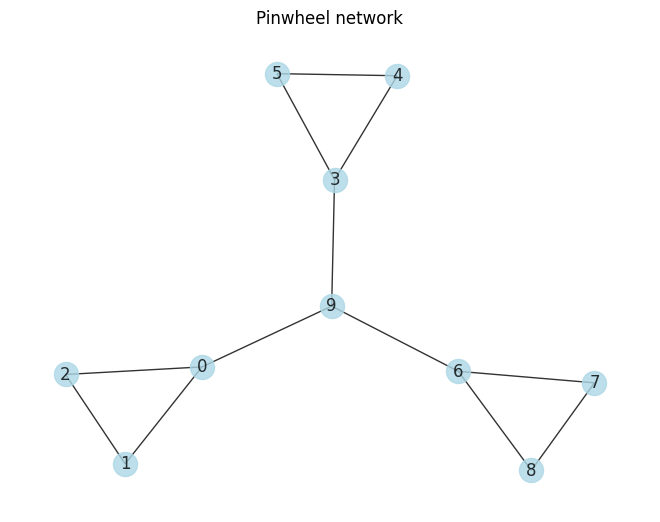

In [10]:
from drawing_utilities import show_graph
import networkx as nx
pinwheel_graph: nx.Graph = nx.Graph()
pinwheel_graph.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
pinwheel_graph.add_edges_from([(0,1), (0,2), (1,2),
                                (3,4), (3,5), (4,5),
                                (6,7), (6,8), (7,8),
                                (9,0), (9,3), (9,6)])
show_graph(pinwheel_graph, title="Pinwheel network")

In the graph, nodes 0, 3, and 6 occupy the same places in the structure. What makes these nodes seem so similar is that they share _similar relationships_ with other nodes in the network. Indeed, nodes 0, 3, and 6 clustered together when we used the notion of eigenvector centrality to define similarity.


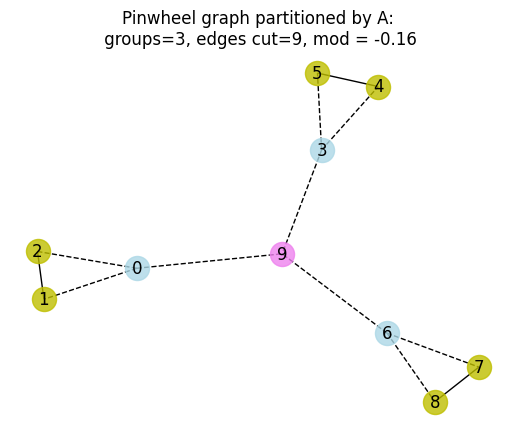

In [11]:
from drawing_utilities import show_partitions
from partitioning_utilities import get_k_leading_eigenvectors_sparse
from partitioning_utilities import get_colors_from_clusters

A = nx.linalg.adjacency_matrix(pinwheel_graph)
leading_vectors = get_k_leading_eigenvectors_sparse(A, 2)
colors = get_colors_from_clusters(leading_vectors, num_clusters=3)

group1 = {node for node in pinwheel_graph.nodes() if colors[node] == 'y'}
group2 = {node for node in pinwheel_graph.nodes() if colors[node] == 'c'}
group3 = {node for node in pinwheel_graph.nodes() if colors[node] == 'm'}

show_partitions(pinwheel_graph, 
                pos = nx.spring_layout(pinwheel_graph),
                partition=(group1, group2, group3), 
                title="Pinwheel graph partitioned by A:\n")

Eigenvector centrality is one form of structural similarity, but there are other forms. Quoting from Hanneman

    "Structural analysts seek to define categories and variables in terms of _similarities_ of the _patterns of relations among actors_, rather than attributes of the actors ...

    "[S]ocial roles or positions are defined by regularities in the patterns of relations among actors" [emphasis added].

Networks represent actors as nodes and relationships between actors as edges. Thus, structural analysts focus on nodes that have similar patterns of relations with other nodes. This idea captures what we see in the pinwheel graph pretty well. 

---


#### Wasserman-Faust Network
Consider the Wasserman-Faust network used by Hanneman.

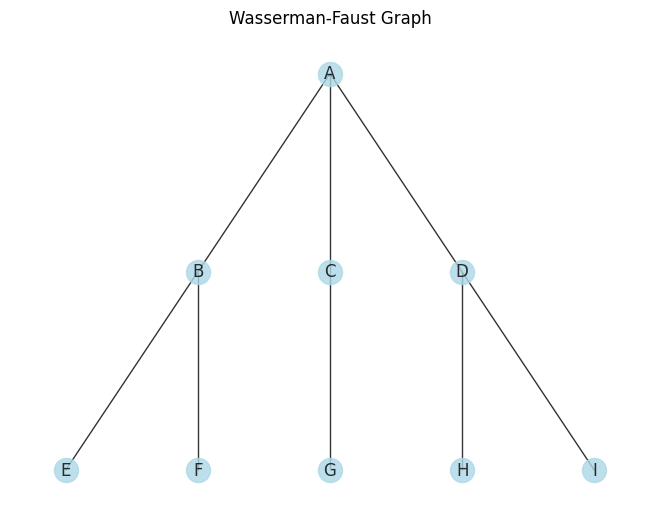

In [12]:
wasserman_faust_graph : nx.Graph= nx.Graph()
wasserman_faust_graph.add_nodes_from(['A','B','C','D','E','F','G','H','I',])
wasserman_faust_graph.add_edges_from([('A','B'),('A','C'),('A','D'),
                                      ('B','E'),('B','F'),
                                      ('C','G'),
                                      ('D','H'),('D','I')])
pos = nx.nx_pydot.graphviz_layout(wasserman_faust_graph,prog="dot")
show_graph(wasserman_faust_graph, pos=pos, title="Wasserman-Faust Graph")


Hanneman argues that vertices B, C, and D are structurally very similar since they connect to a parent and to some children. Similarly, vertices E, F, G, H, and I are structurally similar since they are are "grandchildren" of the same node. 

Let's discuss some of the ways that people have defined structural similarity, using Hanneman as the guide.

---

### Structural equivalence

The idea of structural equivalence is based very literally on the idea that two nodes that have the same relationship structures with other nodes belong in the same _equivalence class_. Structural equivalence emphasizes shared neighbors. In figure 7.11a, Newman illustrates this by the following figure.

<img src="figures/structural_equivalence.png" alt="Structural equivalence from Newman figure 7.11" width = "500">

Newman says that nodes $i$ and $j$ are structurally equivalent because they "... share, in this case, three of the same neighbors, although both [node $i$ and node $j$] also have other neighbors that are not shared." 

The problem with defining structural equivalence only in terms of common neighbors is that it can be very limiting. For the Wasserman-Faust graph, the equivalence classes are
  - $\{A\}$ because it is a hub node.
  - $\{B,C, D\}$ because they are all attached to node $A$.
  - $\{E,F\}$ because they are all at the ends of a spoke and share neighbor $B$.
  - $\{H,I\}$ because they are all at the ends of a spoke and share neighbor $D$.
  - $\{G\}$ because it is at the end of a spoke and has no siblings.
I don't know about you, but this seems overly strict. My instinct says that nodes $E$, $F$, $G$, $H$, and $I$ belong with the other spoke ends since they are the same distance from the hub and their parents are siblings.  That leads to a slightly different notion of structural equivalence.
---


### Regular Equivalence

**General Idea:**

Hanneman defines regular equivalence as follows:

"Two nodes are said to be regularly equivalent if they have the same profile of ties with members of other sets of actors that are also regularly equivalent."

Newman (page 195) says:

"[The definition of] regular equivalence is more subtle [than the definition of structural equivalence]. Two regularly equivalent nodes do not necessarily share the same neighbors, but they have neighbors who are themselves similar."


**Newman's Illustration of Regular Equivalance**

Newman illustrates with the following network.

<img src="figures/regular_equivalence.png" alt="Regular equivalence from Newman figure 7.11" width = "500"> 

Nodes $i$ and $j$ are regularly equivalent because, although they "... do not necessarily share the same neighbors, ... they have neighbors _who are themselves similar_" [page 195, emphasis added]. Note that the two nodes do not even have to share any common neighbors to be structurally equivalent.

These statements show that the definition of regular equivalence is recursive. Importantly, regular equivalence is defined differently depending on what paper you read (see [Audenaert P, Colle D, Pickavet M. Regular Equivalence for Social Networks. Applied Sciences. 2019; 9(1):117](https://doi.org/10.3390/app9010117).) I'll try to teach the intuition and not worry too much about a precise definition.



**Roles**

The key idea in regular equivalence is the idea of a _role_. A role is a specification of what the kinds of edge relations a node has with other roles. We've been using roles to help build understanding about structural similarity: hub, grandparent, child, parent, sibling, grand child, spoke, end of spoke.

For the __pinwheel__ network, the roles and equivalence classes seem pretty intuitive to me. Indeed, I think the __pinwheel__ network illustrates regular equivalence well:
  - $\{2,3,5,6,8,9\}$ are equivalent because they are each part of a three-node clique and only connected to other nodes within the clique.
  - $\{1,4,7\}$ are equivalent because they are each part of a three and are also connected to a hub node.
  - $\{10\}$ is in its own equivalence class because it isn't like any other node in the graph.

For the Wasserman-Faust graph, we can define three relationship patterns (parent, child, leaf) and then use these relationship patterns to define roles.  These roles define the following node sets:
  - $\{E,F,G,H,I\}$ are children nodes that are leaf nodes and not parent nodes. 
  - $\{B,C,D\}$ are children nodes that are also parent nodes.
  - $\{A\}$ is a parent node that is not a child node.
This is still a little imprecise, but it allows us to start creating methods for identifying nodes that have similar roles.

---

### Random walks

A _random walk_ is a path from a staring node that chooses randomly from the neighbors of the current node. Surprisingly, random walks are very effective at finding structurally similar nodes. The idea is that two nodes are structurally similar if they appear with a similar frequence on the paths produced by random walks. We'll continue this discussion after illustrating a random walk on the Karate graph.


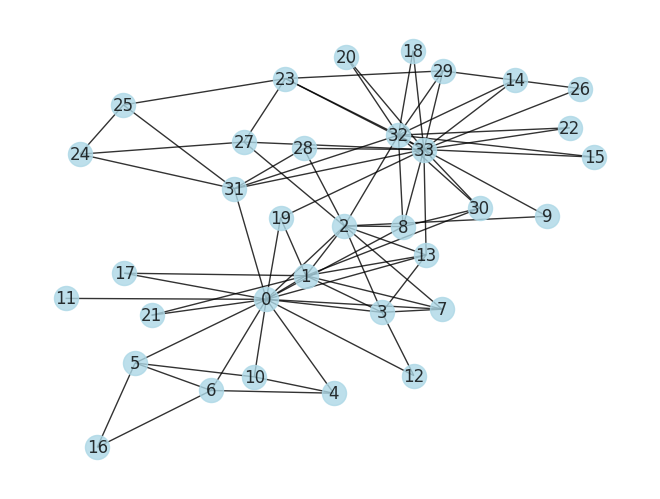

In [14]:
G = nx.karate_club_graph()
colormap = ['y' for nodes in list(G.nodes())]
#pos = nx.nx_agraph.graphviz_layout(G,prog='neato')
show_graph(G)

Let's begin a random walk at node 16 (lower right). More precisely, let's begin a bunch of random walks at node 16 and then see which nodes appear most frequently on this set of random walks.

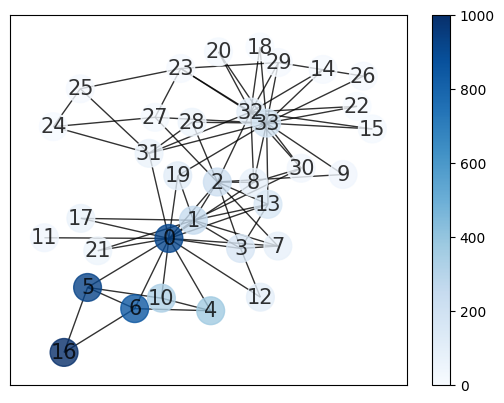

In [15]:
import numpy as np
import matplotlib.pyplot as plt

number_visits_dict = dict([(node,0) for node in list(G.nodes())])
total_nodes_visited = 0
walk_length = 10
num_trials = 100
starting_node = 16
for trials in range(num_trials):
    current_node = starting_node
    #print("node = ", current_node, "visited", number_visits_dict[current_node],"times")
    for step in range(walk_length):
        total_nodes_visited += 1
        number_visits_dict[current_node] += 1
        neighbors = list(G.neighbors(current_node))
        current_node = np.random.choice(neighbors)
values = [number_visits_dict[node] for node in number_visits_dict.keys()]
color_map = plt.get_cmap('Blues')
nx.draw_networkx(G,pos, with_labels = True, cmap = color_map,node_color = values, node_size = 400,font_size = 15, alpha = 0.8)
sm = plt.cm.ScalarMappable(cmap = color_map,norm=plt.Normalize(vmin = 0, vmax=total_nodes_visited))
_ = plt.colorbar(sm, ax=plt.gca())

The random walk starts at node 16 so naturally that node has the most visits. Node 16 only has two neighbors, nodes 5 and 6, so they also have a lot of visits. But look at node 0. It has the second most visits on the random walk because it is a hub in the local neighborhood. And even node 33 has a few visits since it's a hub in an adjacent neighborhood. Thus, random walks consider not only the immediate neighborhood but also broader neighborhood properties. "Random [walks] look at both local ahd higher order neighborhood information" (quoting from Stanford (Graph Machine Learning course)[https://www.youtube.com/watch?v=Xv0wRy66Big] minute 4:45).



Which nodes are important if I start random walks at each of the nodes at the graph and see which nodes are visited the most? Since I'll do this a couple of times, I'll define a pretty ad hoc function that cobbles together random walk and plotting utilities.

In [16]:
class DeepWalk:
    def __init__(self, G, walk_length = 10, positions = None) -> None:
        self.G: nx.Graph = G
        self.number_visits_dict: dict = dict([(node,0) for node in list(self.G.nodes())])
        self.num_trials = 1000
        self.walk_all_nodes(walk_length)
        if positions is None:
            self.positions = nx.nx_pydot.graphviz_layout(self.G,prog="neato")
        else: self.positions = positions
    def walk_all_nodes(self, walk_length = 10) -> None:
        for node in self.G.nodes:
            self.__random_walk__(node, walk_length)
    def get_values(self):
        return [self.number_visits_dict[node] for node in self.number_visits_dict.keys()]
    def get_total_nodes_visited(self):
        return sum(self.number_visits_dict.values())
    def __random_walk__(self, starting_node, walk_length) -> None:
        for _ in range(self.num_trials):
            self.__random_walk_trial__(starting_node, walk_length)
    def __random_walk_trial__(self, starting_node, walk_length) -> None:
        current_node = starting_node
        for _ in range(walk_length):
            self.number_visits_dict[current_node] += 1
            neighbors = list(self.G.neighbors(current_node))
            current_node = np.random.choice(neighbors)
    def show_graph(self):
        values = self.get_values()
        max_value = self.get_total_nodes_visited() 
        color_map = plt.get_cmap('Blues')
        nx.draw_networkx(self.G,self.positions, with_labels = True, cmap = color_map,node_color = values, node_size = 400,font_size = 15, alpha = 0.8)
        sm = plt.cm.ScalarMappable(cmap = color_map,norm=plt.Normalize(vmin = 0, vmax=max_value))
        _ = plt.colorbar(sm, ax=plt.gca())


Let's run the karate graph through this and see how the count of node visits helps reveal structural similarities between nodes.

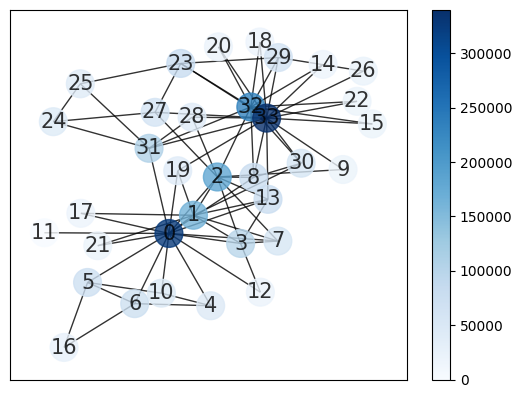

In [17]:
my_walker = DeepWalk(G, walk_length = 10)
my_walker.show_graph()

Observe a few things, which I'll frame using italicized roles.
  - _Leaf_ nodes (node 11) are rarely visited on any of the random walks.
  - _Hub_ nodes (nodes 0 and 33) have high degree and are visited a lot on random walks.
  - _Path_ nodes (nodes 1, 2, and 32) are visited moderately often because they connect hub nodes.
  - _Cycle_ nodes (node group 4, 5, 6, and 10, and node group 23, 24, 25, and 27) are local communities some distance from hubs but which tend to get visited by random walks that originate within or near the node group.

Nodes that have similar structures are visited similarly often on a random walk. Let's just lump the _structural equivalence_ and _relational equivalence_ into the same category since both definitions say two nodes are similar if they are part of similar structures in the graph. We'll call them both simply _structural similarity_. This lead to an observation:

__Random walks visit structurally similar nodes about the same number of times__. 

---


Let's check this assertion by looking at the plots of how often nodes are visited for the pinwheel graph and the Wasserman-Faust graph. 

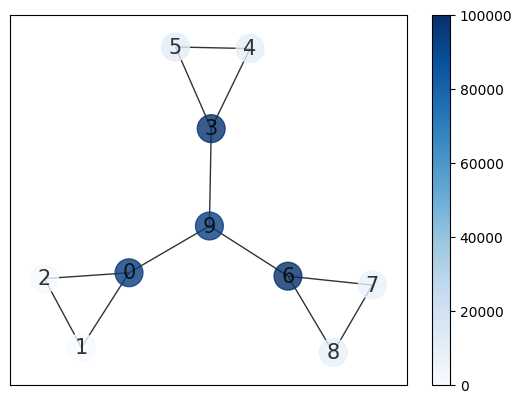

In [18]:
my_walker = DeepWalk(pinwheel_graph, walk_length = 10)
my_walker.show_graph()

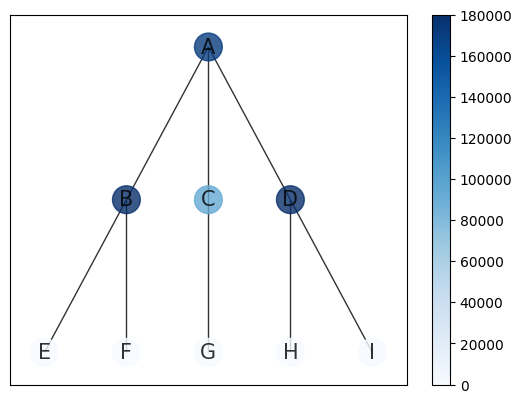

In [19]:
pos = nx.drawing.nx_pydot.graphviz_layout(wasserman_faust_graph,prog="dot")
my_walker = DeepWalk(wasserman_faust_graph, walk_length = 20,positions = pos)
my_walker.show_graph()

Random walks tend to "assign similar scores" to nodes that play similar roles, though the different values between node C and nodes B and D in the Wasserman-Faust graph indicate that the roles are implicit. In other words, the roles are not defined according to some pattern decided by a supervisor. Rather, the roles are defined by the scores produced by the random walk.

---